In [1]:
import numpy as np
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_trendfilter

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

Signal-to-noise ratio: 0.026


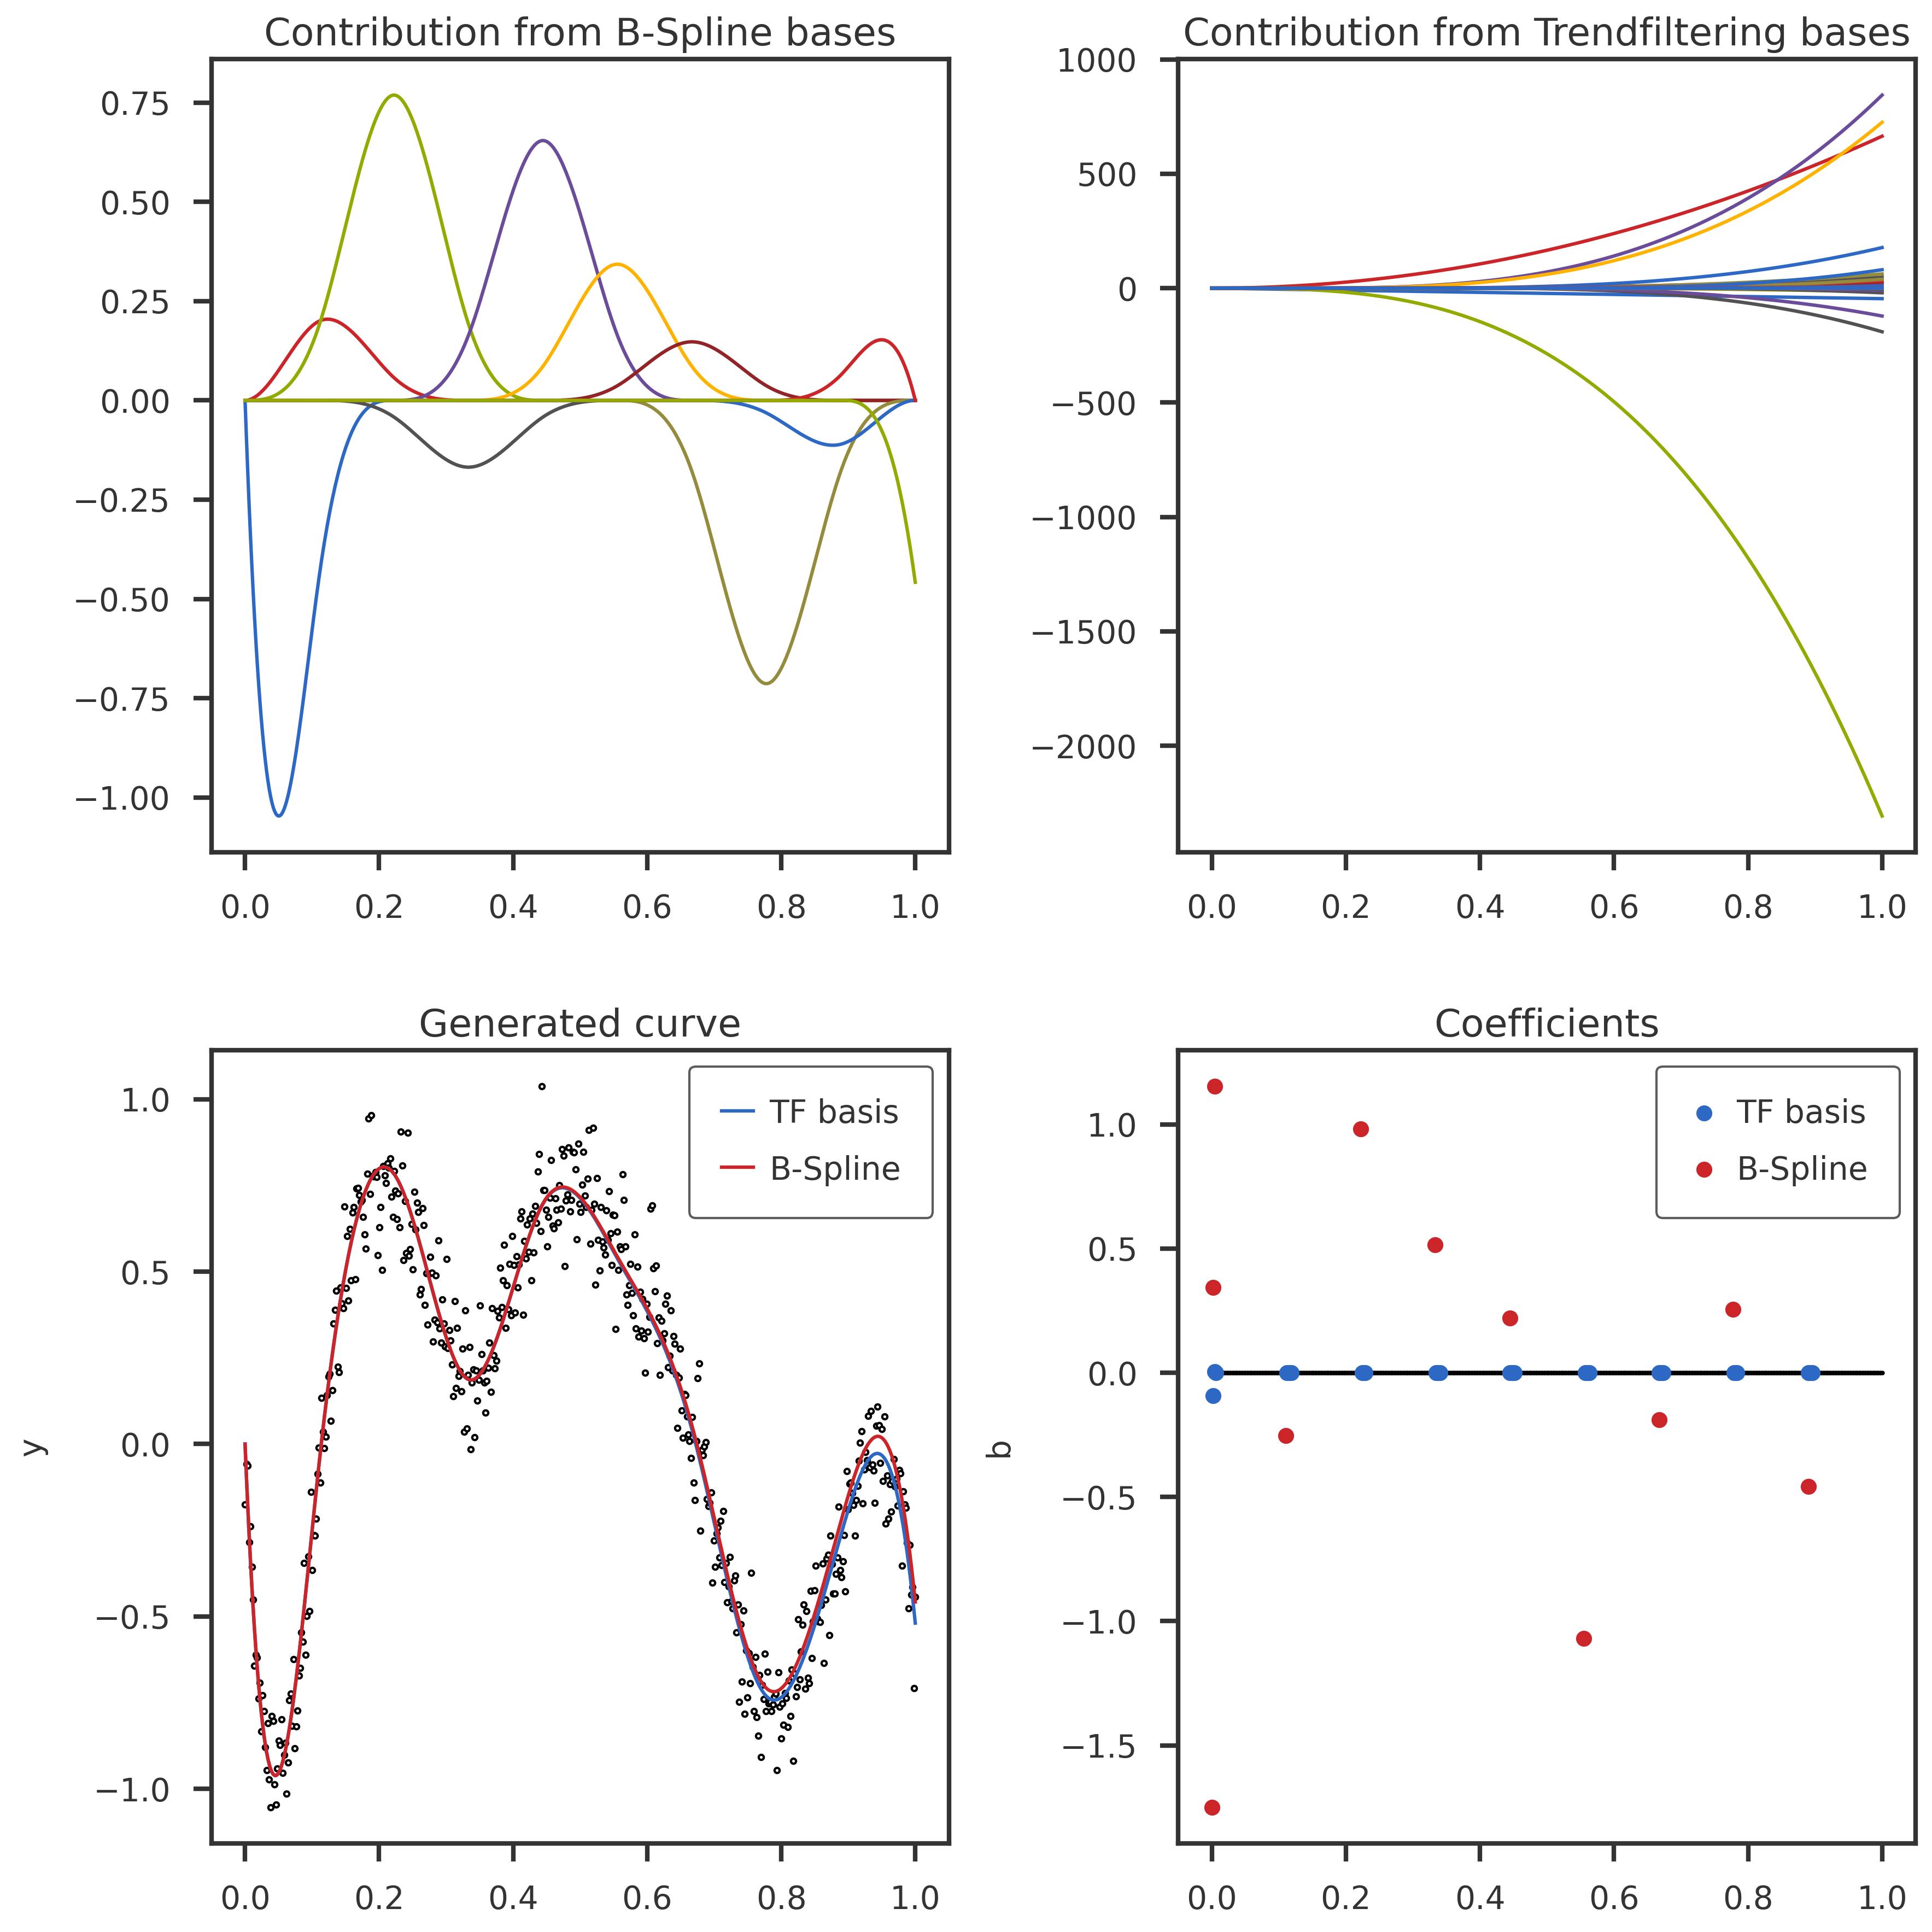

In [2]:
n = 500
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
nknots = 8
degree = 3
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, nknots+2)[1:-1]
bfix = np.random.normal(0, 1, size = nknots + degree)


H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-8
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue, show_base_legend = False)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [3]:
def center_and_scale_tfbasis(Z, b):
    '''
    Basis matrix Z is always 2D.
    b is the coefficient vector
    The first column of Z is all 1, hence it has zero standard deviation.
    '''
    dim  = Z.ndim
    std  = np.std(Z, axis = 0)
    if std[0] == 0:
        # do not scale the first column
        std[0] = 1.0
    Znew = Z / std
    Znew[:, 1:] = Znew[:, 1:] - np.mean(Znew[:, 1:], axis = 0).reshape(1, -1)
    bnew = b * std
    ## add the intercept
    bnew[0] = - np.sum(Znew[0, :] * bnew)
    '''
    alternative
    bnew = np.dot(np.dot(np.linalg.inv(Znew), Z), b)
    '''
    return Znew, bnew

Hscale, bscale = center_and_scale_tfbasis(H, btrue)
dj = np.sum(np.square(Hscale), axis = 0)
print (dj)

[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 

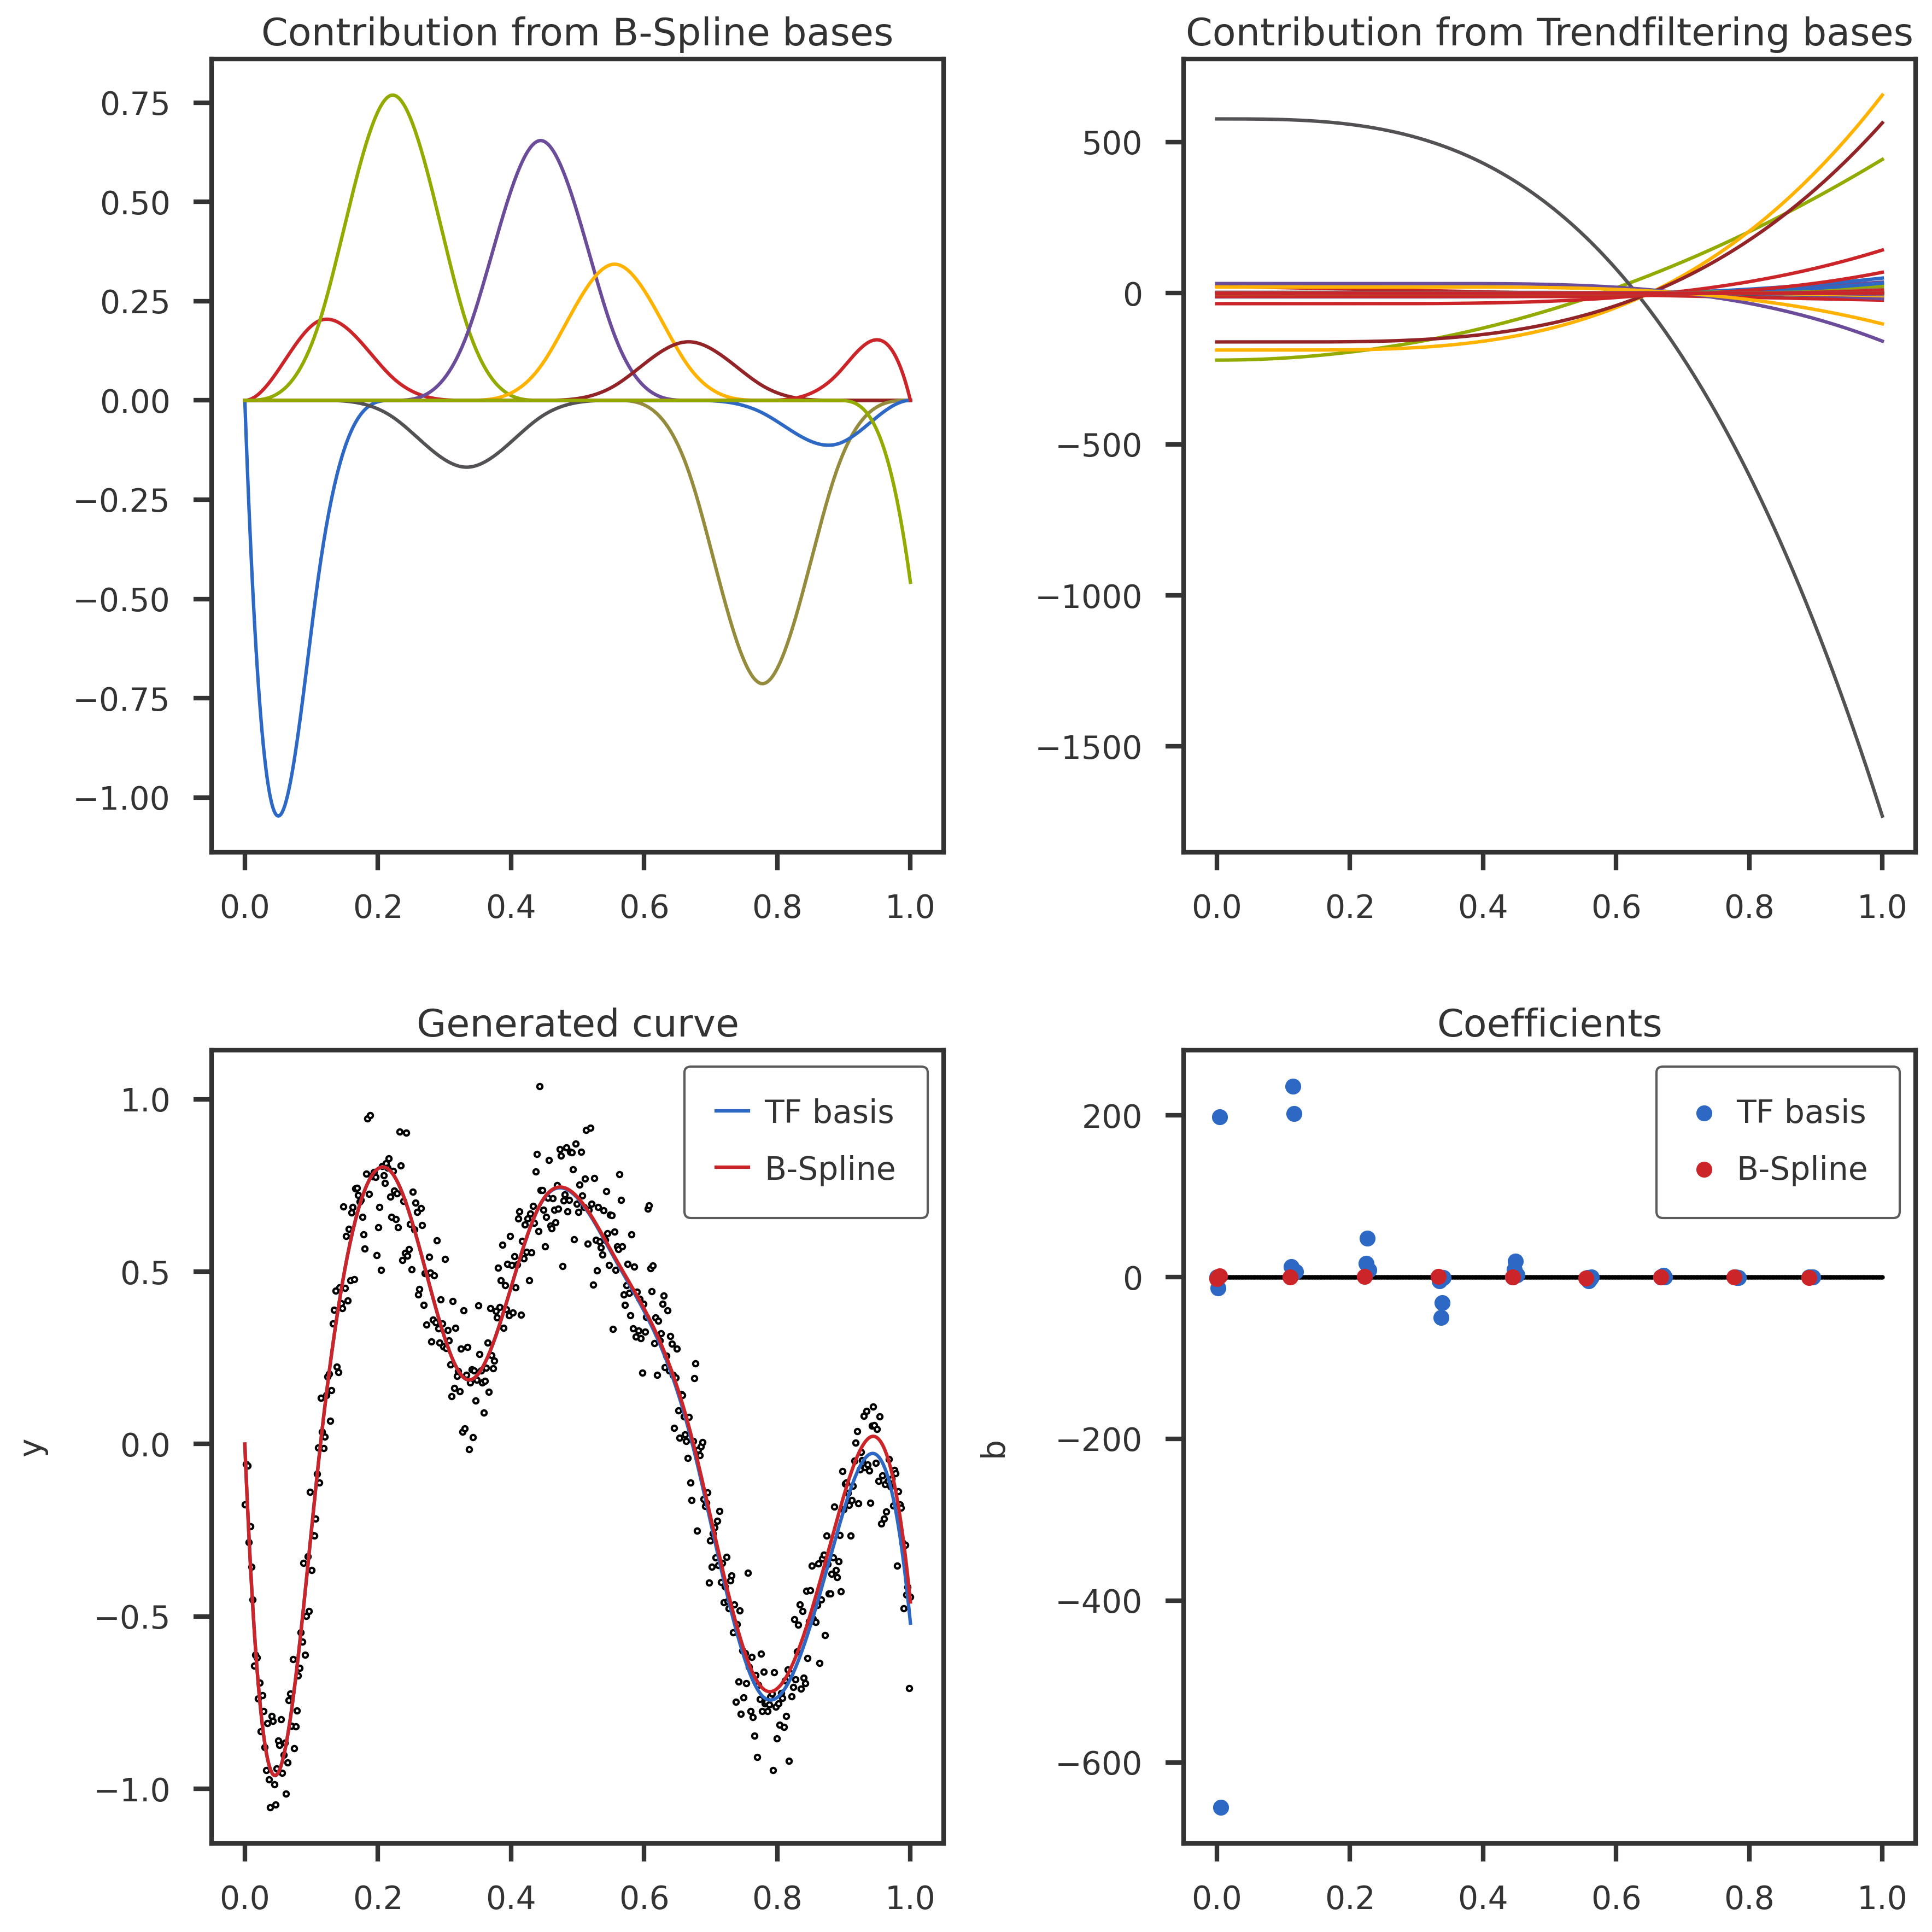

In [4]:
fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, Hscale, bscale, show_base_legend = False)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

In [5]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)
tf_basis_inv = model.trendfiltering_basis_matrix_inverse(n, degree) 
tf_bhat  = np.dot(tf_basis_inv, tf_y)

R[write to console]: Loading required package: Matrix



Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [6]:
k = 20
scale = 10.0
s2init = np.var(y - np.dot(H, tf_bhat))
_, binit = center_and_scale_tfbasis(H, tf_bhat)
winit, sk = initialize_ash_prior(k, scale = scale, sparsity = 0.8)
print (r"Standard deviation of components in Gaussian scale mixture:")
print (', '.join([f"{x:.3f}" for x in sk]))
print ()
print ("Coefficients of components in Gaussian scale mixture (initial values):")
print (', '.join([f"{x:.3f}" for x in winit]))

Standard deviation of components in Gaussian scale mixture:
0.000, 0.122, 0.259, 0.413, 0.585, 0.778, 0.995, 1.239, 1.512, 1.818, 2.162, 2.548, 2.981, 3.467, 4.012, 4.623, 5.310, 6.079, 6.943, 7.913

Coefficients of components in Gaussian scale mixture (initial values):
0.800, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011, 0.011


In [7]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "rds", debug = False)
mrash_r.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init, maxiter = 20000)

2022-04-06 11:58:18,724 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 20000.



In [8]:
'''
mr.ash.pen
'''
plr_lbfgs_noinit = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'fortran',
                debug = False, display_progress = False, calculate_elbo = True,
                maxiter = 10000, tol = 1e-8)
plr_lbfgs_noinit.fit(Hscale, y, sk, binit = binit, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 521.


In [12]:
'''
mr.ash.pen (inverse)
'''
import mrashpen_inverse
from scipy import optimize as sp_optimize

def plr_obj_func_Minv(params, X, y, sk, s2, dj, softmax_base = np.exp(1)):
    n, p = X.shape
    k = sk.shape[0]
    b = params[:p]
    a = params[p:]
    r = y - np.dot(X, b)
    rTr = np.dot(r, r)
    Pb, dPdb, dPda = mrashpen_inverse.penalty_func(b, a, np.sqrt(s2), sk, dj,
                                    jac = True, 
                                    softmax_base = softmax_base, 
                                    method = 'fssi-linear',
                                    ngrid = 1000)
    H = 0.5 * rTr / s2 + Pb
    dHdb = - np.dot(r.T, X) / s2
    dHdb += dPdb
    return H, np.concatenate((dHdb, dPda))

ainit = np.log(winit)
initparams = np.concatenate((binit, ainit))
opt_min = sp_optimize.minimize(plr_obj_func_Minv, initparams,
                               args = (Hscale, y, sk, s2init, dj),
                               method = 'l-bfgs-b', jac = True,
                               #options = {'disp': True, 'maxiter': 10, 'return_all': True}
                               options = {'disp':True, 'maxiter': 20000}
                              )

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          520     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29018D+05    |proj g|=  7.94317D+03

At iterate    1    f=  2.28816D+05    |proj g|=  4.30675D+03

At iterate    2    f=  2.28722D+05    |proj g|=  3.31115D+03

At iterate    3    f=  2.28684D+05    |proj g|=  3.54332D+03

At iterate    4    f=  2.28555D+05    |proj g|=  2.86628D+03

At iterate    5    f=  2.28501D+05    |proj g|=  1.79708D+03

At iterate    6    f=  2.28451D+05    |proj g|=  9.21372D+02

At iterate    7    f=  2.28410D+05    |proj g|=  9.71082D+02

At iterate    8    f=  2.28377D+05    |proj g|=  7.14253D+02

At iterate    9    f=  2.28365D+05    |proj g|=  6.16957D+02

At iterate   10    f=  2.28346D+05    |proj g|=  6.17282D+02

At iterate   11    f=  2.28335D+05    |proj g|=  6.05977D+02

At iterate   12    f=  2.28328D+05    |proj g|=  7.01224D+02

At iterate   13    f=  2.2


At iterate  139    f=  3.38491D+04    |proj g|=  2.55333D+03

At iterate  140    f=  3.38310D+04    |proj g|=  2.43397D+03

At iterate  141    f=  3.38185D+04    |proj g|=  2.58299D+03

At iterate  142    f=  3.37907D+04    |proj g|=  2.38471D+03

At iterate  143    f=  3.37789D+04    |proj g|=  2.76913D+03

At iterate  144    f=  3.37513D+04    |proj g|=  2.49806D+03

At iterate  145    f=  3.37442D+04    |proj g|=  2.69167D+03

At iterate  146    f=  3.37369D+04    |proj g|=  2.71792D+03

At iterate  147    f=  3.37218D+04    |proj g|=  2.49966D+03

At iterate  148    f=  3.37112D+04    |proj g|=  2.63144D+03

At iterate  149    f=  3.37044D+04    |proj g|=  2.71128D+03

At iterate  150    f=  3.36857D+04    |proj g|=  2.52238D+03

At iterate  151    f=  3.36638D+04    |proj g|=  2.78452D+03

At iterate  152    f=  3.36338D+04    |proj g|=  2.89070D+03

At iterate  153    f=  3.36011D+04    |proj g|=  2.50894D+03

At iterate  154    f=  3.35852D+04    |proj g|=  2.48969D+03

At iter


At iterate  273    f=  3.24481D+04    |proj g|=  2.34717D+03

At iterate  274    f=  3.24458D+04    |proj g|=  2.35314D+03

At iterate  275    f=  3.24426D+04    |proj g|=  2.45818D+03

At iterate  276    f=  3.24346D+04    |proj g|=  2.61957D+03

At iterate  277    f=  3.24306D+04    |proj g|=  2.48516D+03

At iterate  278    f=  3.24285D+04    |proj g|=  2.66424D+03

At iterate  279    f=  3.24274D+04    |proj g|=  2.70789D+03

At iterate  280    f=  3.24267D+04    |proj g|=  2.62521D+03

At iterate  281    f=  3.24242D+04    |proj g|=  2.34293D+03

At iterate  282    f=  3.24220D+04    |proj g|=  2.59470D+03

At iterate  283    f=  3.24215D+04    |proj g|=  2.55480D+03

At iterate  284    f=  3.24205D+04    |proj g|=  2.56005D+03

At iterate  285    f=  3.24198D+04    |proj g|=  2.58649D+03

At iterate  286    f=  3.24186D+04    |proj g|=  2.37825D+03

At iterate  287    f=  3.24184D+04    |proj g|=  2.32700D+03

At iterate  288    f=  3.24173D+04    |proj g|=  2.53270D+03

At iter


At iterate  412    f=  3.19785D+04    |proj g|=  2.31332D+03

At iterate  413    f=  3.19779D+04    |proj g|=  2.29414D+03

At iterate  414    f=  3.19772D+04    |proj g|=  2.27985D+03

At iterate  415    f=  3.19769D+04    |proj g|=  2.28341D+03

At iterate  416    f=  3.19764D+04    |proj g|=  2.28788D+03

At iterate  417    f=  3.19762D+04    |proj g|=  2.29855D+03

At iterate  418    f=  3.19758D+04    |proj g|=  2.28067D+03

At iterate  419    f=  3.19757D+04    |proj g|=  2.26376D+03

At iterate  420    f=  3.19753D+04    |proj g|=  2.32409D+03

At iterate  421    f=  3.19746D+04    |proj g|=  2.33755D+03

At iterate  422    f=  3.19740D+04    |proj g|=  2.35490D+03

At iterate  423    f=  3.19729D+04    |proj g|=  2.36697D+03

At iterate  424    f=  3.19726D+04    |proj g|=  2.37140D+03

At iterate  425    f=  3.19722D+04    |proj g|=  2.37451D+03

At iterate  426    f=  3.19719D+04    |proj g|=  2.35999D+03

At iterate  427    f=  3.19717D+04    |proj g|=  2.33351D+03

At iter

In [13]:
bhat = opt_min.x[:binit.shape[0]]
what = mrashpen_inverse.softmax(opt_min.x[binit.shape[0]:])

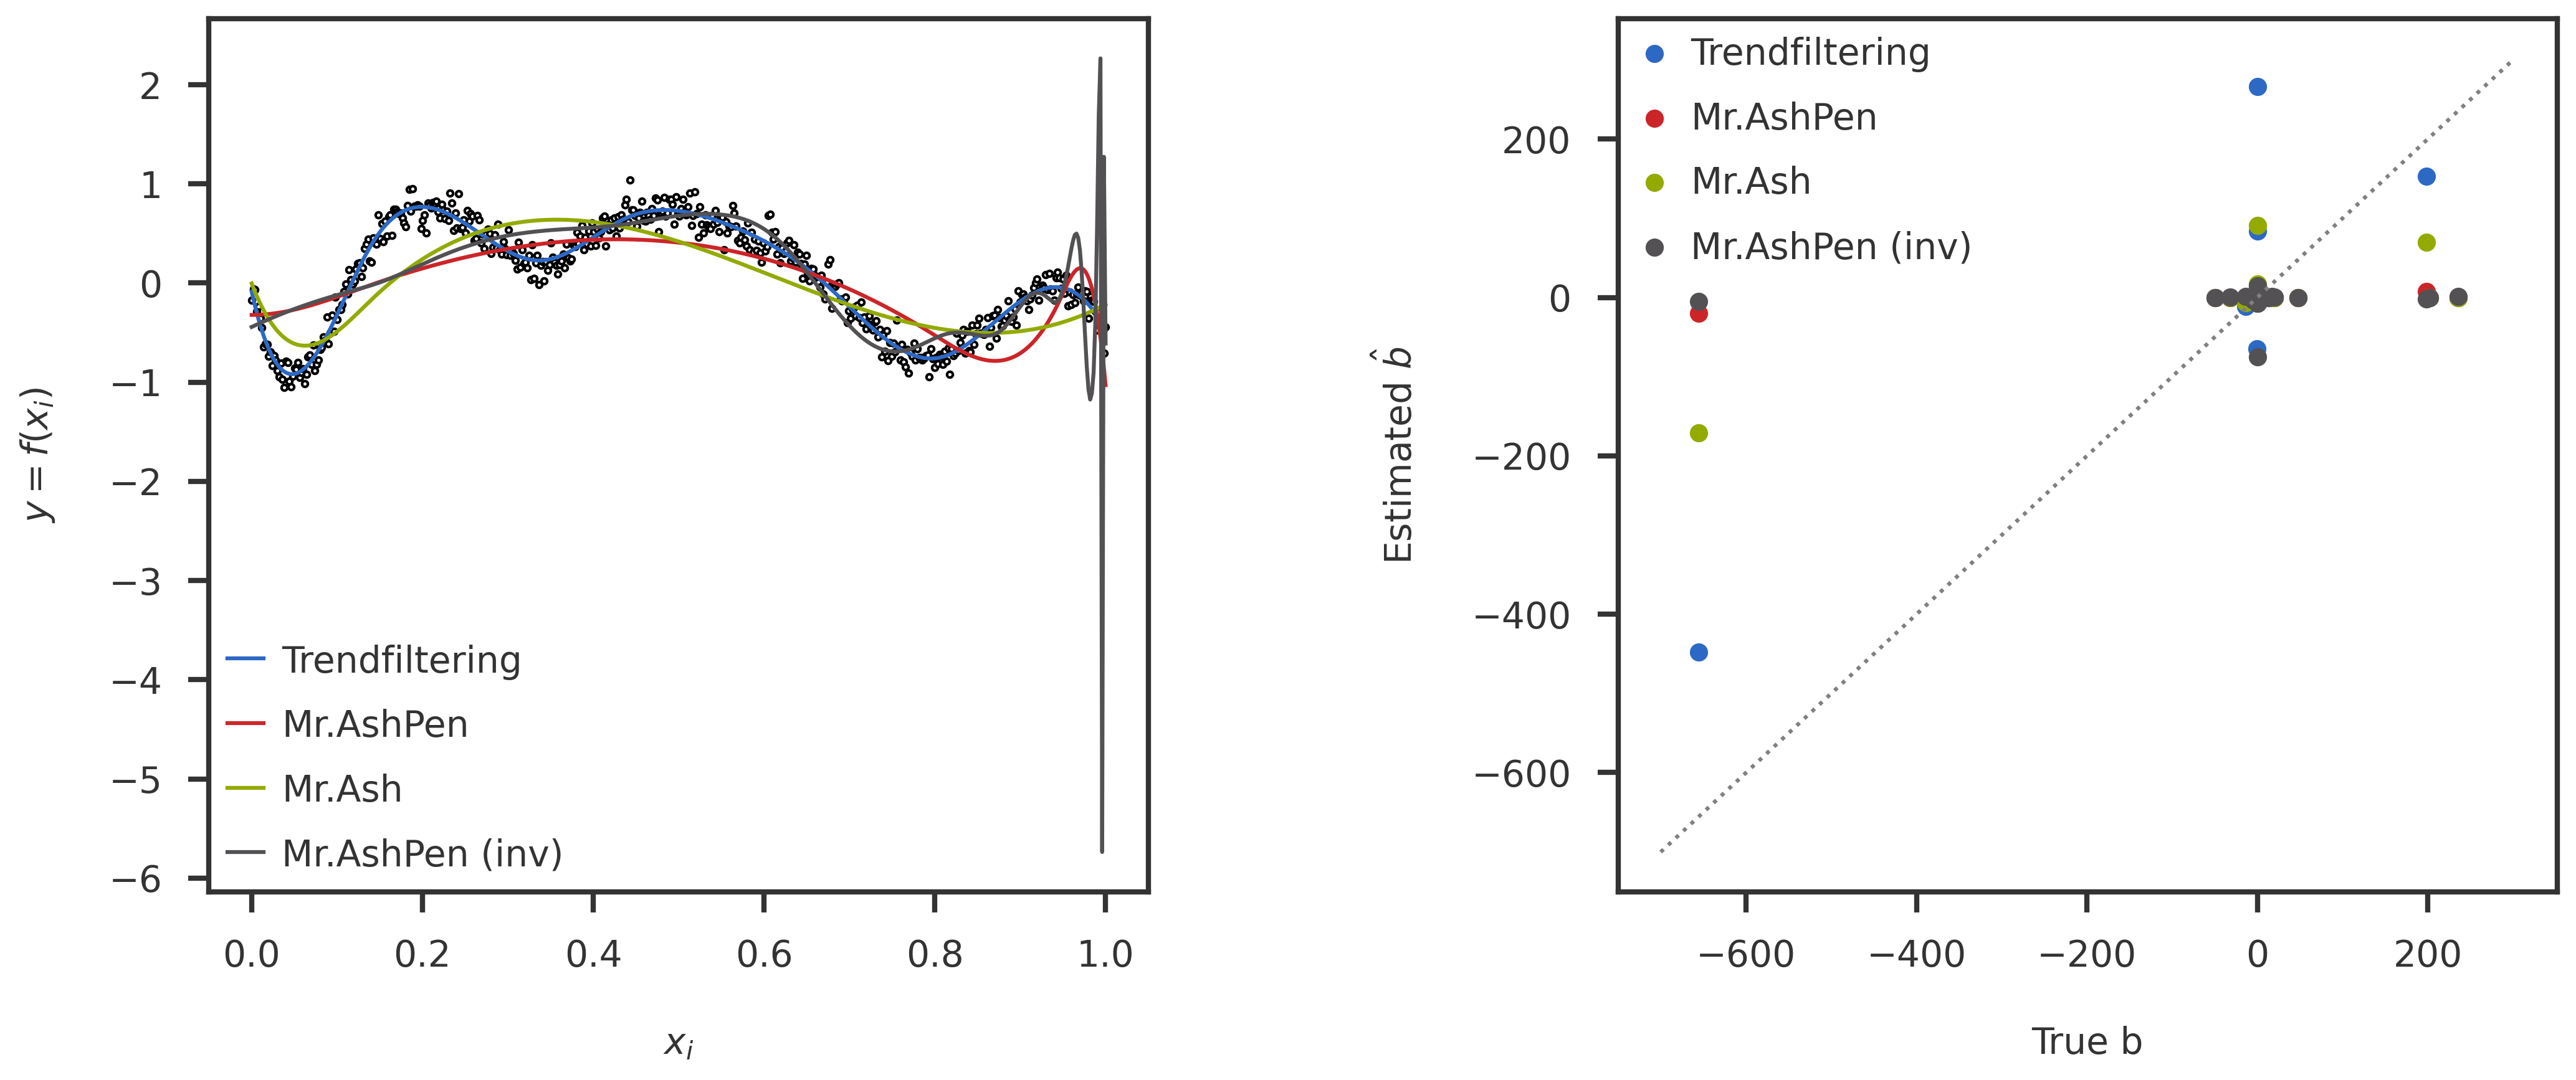

In [15]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
#ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, np.dot(Hscale, plr_lbfgs_noinit.coef), label = "Mr.AshPen")
ax1.plot(x, np.dot(Hscale, mrash_r.coef), label = "Mr.Ash")
ax1.plot(x, np.dot(Hscale, bhat), label = "Mr.AshPen (inv)")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(bscale, binit, label = "Trendfiltering")
ax2.scatter(bscale, plr_lbfgs_noinit.coef, label = "Mr.AshPen")
ax2.scatter(bscale, mrash_r.coef, label = "Mr.Ash")
ax2.scatter(bscale, bhat, label = "Mr.AshPen (inv)")
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

# fig = plt.figure(figsize = (12, 6))
# ax1 = fig.add_subplot(111)
# objs = [mrash_r.obj_path, plr_lbfgs_noinit.elbo_path]
# methods = ["Mr.Ash", "Mr.AshPen"]
# nwarm = [0, 0]
# objmin  = np.min([np.min(x) for x in objs])
# for obj, method, iteq in zip(objs, methods, nwarm):
#     m_obj = np.array(obj)[iteq:] - objmin
#     m_obj = m_obj[m_obj > 0]
#     ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
#              marker = 'o', markersize = 1)
# ax1.legend()
# ax1.set_xlabel("Number of Iterations")
# ax1.set_ylabel("log( max(ELBO) - ELBO )")
# plt.show()

### Coefficients of components in Gaussian scale mixture

In [16]:
print ("Mr.Ash:")
print (', '.join([f"{x:.3f}" for x in mrash_r.prior[:, 0]]))
print ()

print ("Mr.AshPen:")
print (', '.join([f"{x:.3f}" for x in plr_lbfgs_noinit.prior]))
print ()

print ("Mr.AshPen (using M-inverse):")
print (', '.join([f"{x:.3f}" for x in what]))
print ()

Mr.Ash:
0.990, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.010

Mr.AshPen:
0.988, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.012

Mr.AshPen (using M-inverse):
1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000

